In [19]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Interactive plots
%matplotlib notebook

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import scipy.signal
import mypackage
import os

plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Read in the 1 to 10 layer plastic film on fillet

In [20]:
file_names = ['20200213_113826_fillet_sample30', '20200213_113854_fillet_sample31', '20200213_113925_fillet_sample32', '20200213_113949_fillet_sample33', '20200213_114007_fillet_sample34', '20200213_114025_fillet_sample35', '20200213_114052_fillet_sample36', '20200213_114111_fillet_sample37', '20200213_114129_fillet_sample38', '20200213_114148_fillet_sample39']

X, Y, info = mypackage.Dataset.load_files(file_names, '../data/tomra')
wavelengths = [928, 932, 935, 939, 942, 946, 950, 953, 957, 960, 964, 968, 971, 975, 978, 982, 986, 989, 993, 997, 1000, 1004, 1007, 1011, 1015, 1018, 1022, 1025, 1029, 1033, 1036, 1040, 1043, 1047, 1051, 1054, 1058, 1061, 1065, 1069, 1072, 1076, 1079, 1083, 1087, 1090, 1094, 1097, 1101, 1105, 1108, 1112, 1115, 1119, 1123, 1126, 1130, 1134, 1137, 1141, 1144, 1148, 1152, 1155, 1159, 1162, 1166, 1170, 1173, 1177, 1180, 1184, 1188, 1191, 1195, 1198, 1202, 1206, 1209, 1213, 1216, 1220, 1224, 1227, 1231, 1234, 1238, 1242, 1245, 1249, 1252, 1256, 1260, 1263, 1267, 1271, 1274, 1278, 1281, 1285, 1289, 1292, 1296, 1299, 1303, 1307, 1310, 1314, 1317, 1321, 1325, 1328, 1332, 1335, 1339, 1343, 1346, 1350, 1353, 1357, 1361, 1364, 1368, 1371, 1375, 1379, 1382, 1386, 1390, 1393, 1397, 1400, 1404, 1408, 1411, 1415, 1418, 1422, 1426, 1429, 1433, 1436, 1440, 1444, 1447, 1451, 1454, 1458, 1462, 1465, 1469, 1472, 1476, 1480, 1483, 1487, 1490, 1494, 1498, 1501, 1505, 1508, 1512, 1516, 1519, 1523, 1527, 1530, 1534, 1537, 1541, 1545, 1548, 1552, 1555, 1559, 1563, 1566, 1570, 1573, 1577, 1581, 1584, 1588, 1591, 1595, 1599, 1602, 1606, 1609, 1613, 1617, 1620, 1624, 1627, 1631, 1635, 1638, 1642, 1645, 1649, 1653, 1656, 1660, 1664, 1667, 1671, 1674]

# _, X = mypackage.Dataset.scale(X_test=None, X_train=X, scale='GlobalStandardization')

In [21]:
X.shape, Y.shape

((10, 100, 100, 208), (10, 100, 100, 1))

In [22]:
for i in range(10):
    print(np.sum([Y[i] == 3] *1))

84
81
95
77
105
107
109
100
122
123


Select 10 pixels to represent just meat

<IPython.core.display.Javascript object>


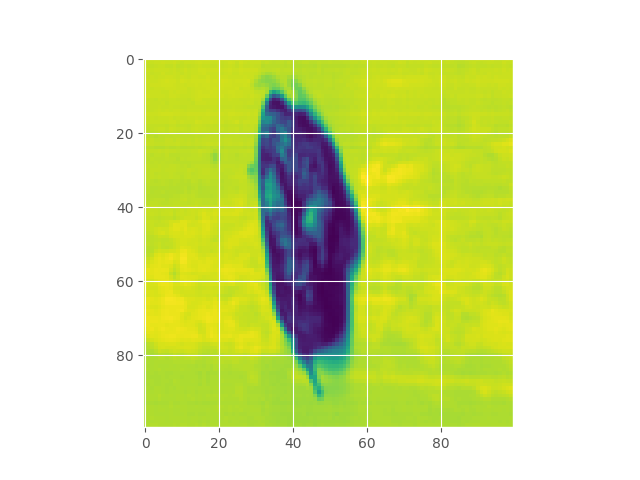

(10, 208)

In [23]:
plt.figure()
plt.imshow(X[0, :, :, 138])
plt.show()

just_meat = X[0, 60:70, 50, :] # 0, 60:70, 50, : Gives 10 good pixels # 0, 60:70, 45:52, : Gives 70 pixels
if len(just_meat.shape) == 3:
    n, m, k = just_meat.shape
    just_meat = just_meat.reshape(n*m, k)
just_meat.shape

The wavelength at index 138 is *1426nm*. This wavelength seems to be good indication of the plastic. This matches with the water ($H_2O$) absorbtion band, which is expected at the range 1400nm to 1460nm

In [33]:
f"Wavelength at index 138 is {wavelengths[138]}nm."

'Wavelength at index 138 is 1426nm.'

Select the top 10 pixels to reprecent the plastic layer

In [25]:
def select_top_N(data, N=10, top='Highest'):
    # https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
    # wavelength at index=138 is 1426nm and that seems to give good scale for meat vs plastic
    sorted_index = data[:, 138].argsort() # This sorts in ascending
    if top == 'Highest':
        sorted_index = sorted_index[::-1] # The [::-1] is to reverse the list (to descending order)
    return data[sorted_index[:N], :]


In [26]:
# wavelength_columns = [f"{i}nm" for i in wavelengths]
columns = ['NumbLayers'] + wavelengths
df = pd.DataFrame(columns=columns)

def add_data_to_df(df, data, numb_layers):
    n = len(data)
    df = df.append(pd.DataFrame(data=np.column_stack(([numb_layers]*n, data)), columns=columns), ignore_index=True)
    return df

df = add_data_to_df(df, just_meat, numb_layers=0)

for i in range(10):
    spectal_pixels = X[i, np.squeeze(Y[i] == 2), :]
    plastic_pixels = select_top_N(spectal_pixels, N=70, top='Highest')
    
    df = add_data_to_df(df, plastic_pixels, numb_layers=i+1)

Plot the average of each pixel group

<IPython.core.display.Javascript object>


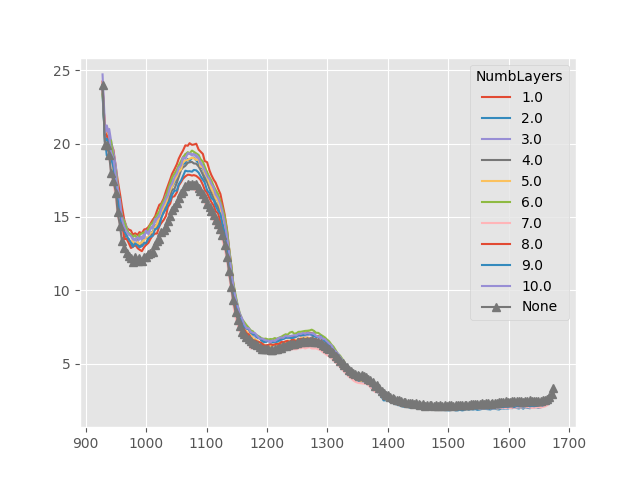

<IPython.core.display.Javascript object>


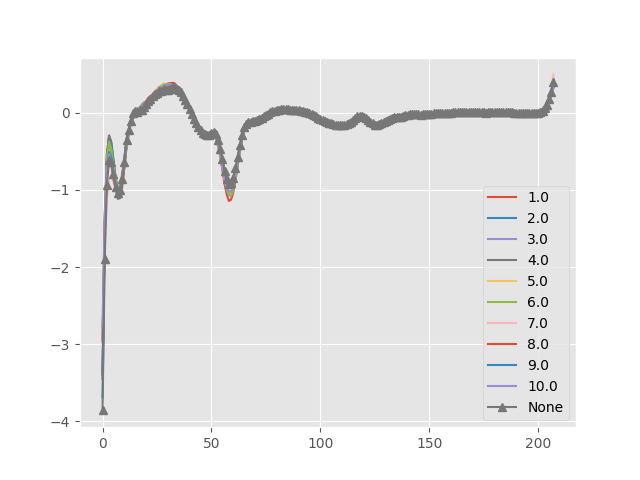

In [27]:
mean_spectra = df[df['NumbLayers'] > 0].groupby('NumbLayers').mean()
mean_spectra.T.plot()
df[wavelengths][df['NumbLayers'] == 0].mean().plot(style='^-', legend='No Film')

w, p = 21, 6
diff_1st = lambda x: scipy.signal.savgol_filter(x, window_length=w, polyorder=p, deriv=1)
diff_2nd = lambda x: scipy.signal.savgol_filter(x, window_length=w, polyorder=p, deriv=2)
mean_spectra = df[df['NumbLayers'] > 0].groupby('NumbLayers').mean().apply(diff_1st, axis=1, result_type='expand')
mean_spectra.T.plot()
plt.plot(diff_1st(df[wavelengths][df['NumbLayers'] == 0].mean()), '^-', label='None') # None == 'No Film'
plt.legend();


In [28]:
df

,NumbLayers,928,932,935,939,942,946,950,953,957,...,1642,1645,1649,1653,1656,1660,1664,1667,1671,1674
0,0.0,23.605150,21.217392,20.569620,18.604650,20.299145,19.552111,17.968750,16.950146,15.365112,...,2.586010,2.635432,2.588162,2.753612,2.601037,2.636760,2.714391,2.822539,3.125740,3.315072
1,0.0,23.918846,19.014084,19.099379,19.521914,18.466522,17.536356,17.412588,16.123400,15.182186,...,3.028218,3.092863,3.217221,3.100032,3.271681,3.253982,3.286255,3.526992,3.655197,4.274702
2,0.0,24.210527,21.024734,21.126760,19.813829,18.558952,17.712811,17.030260,15.971815,15.345529,...,3.541985,3.740764,3.614740,3.488093,3.631285,3.642412,3.685956,3.957865,3.910879,4.431087
3,0.0,23.429180,17.443869,17.582417,18.601583,17.405405,16.479725,15.651558,14.361702,13.385013,...,3.136686,3.164801,3.116393,3.149732,3.161109,3.165591,3.257869,3.505535,3.643201,3.973139
4,0.0,23.275408,18.914186,18.224298,18.543045,16.225166,15.969256,15.796799,13.727811,12.857143,...,2.421674,2.351676,2.398941,2.258809,2.369629,2.399044,2.471745,2.686964,2.956644,3.412401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,10.0,23.243530,22.495605,21.138210,21.109608,20.935411,19.823009,18.265814,16.903915,16.409464,...,2.326827,2.434716,2.376643,2.437449,2.508278,2.663208,2.710983,2.701050,2.967394,3.092639
106,10.0,25.092642,21.317158,21.327013,21.883289,19.176598,19.051725,17.443502,15.588235,15.636177,...,1.990470,2.133602,1.993068,2.002746,2.079867,2.148386,2.363161,2.342530,2.697195,3.012730
107,10.0,23.382820,21.913044,19.778481,20.158104,19.264069,19.187553,17.205055,17.411491,16.130653,...,2.228623,2.395164,2.329217,2.276540,2.431611,2.544048,2.527310,2.575680,2.873496,3.125000
108,10.0,25.445961,21.869488,21.924290,20.472443,19.851379,18.907200,17.724138,17.016317,16.650049,...,2.254573,2.310480,2.196620,2.398422,2.340839,2.430556,2.469473,2.641510,2.794083,3.186920


In [29]:
df_1stDiff = df[wavelengths][df['NumbLayers'] > 0].apply(diff_1st, axis=1, result_type='expand')
df_1stDiff['NumbLayers'] = df['NumbLayers']

In [30]:
# df_2ndDiff = df[wavelengths][df['NumbLayers'] > 0].apply(diff_2nd, axis=1, result_type='expand')
# df_2ndDiff['NumbLayers'] = df['NumbLayers']

Run the PLS analisys on the pixel groups 0 to 10 layers of plastic, or 1 to 10 layers

Test out the "Moving Window PLS" to find if a spectral subset is better

Test out the first and second derivative to see if the results do improve

50% completed
Suggested number of components:  16

R2 calib: 0.991
R2 CV: -1.532
MSE calib: 0.092
MSE CV: 25.321


<IPython.core.display.Javascript object>


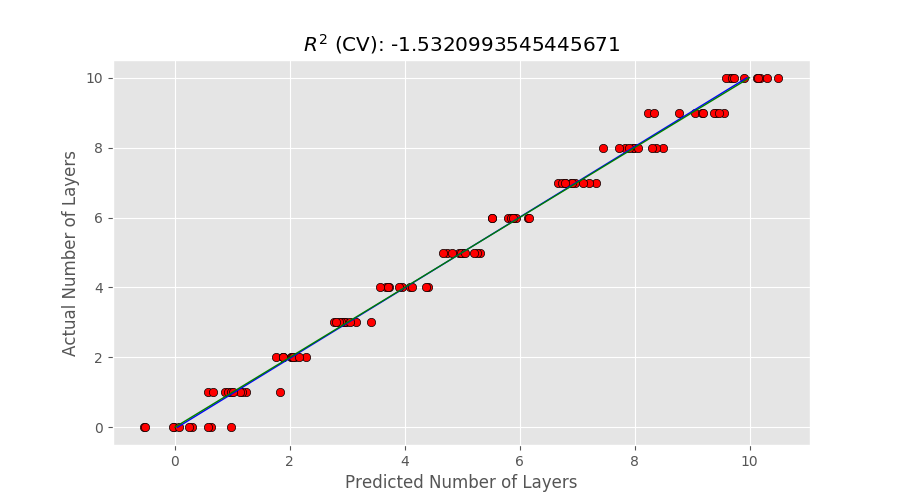

Precentage of correctly classified number of plastic layers: 0.49%
Precentage of correctly classified   meat vs plastic film(s): 0.95%


In [31]:
def test_pls_classifier(X, Y):
    pls_classifier = mypackage.PLS.optimise_pls_cv(X, Y, 20, plot_result=True)

    ######################################
    # Counting correctly classified items
    Y_hat = np.floor(pls_classifier.predict(X))
    Y_hat[Y_hat < 0] = 0

    numb_correct_layers = np.sum((np.squeeze(Y_hat) - Y) == 0)
    numb_correct_plastic_or_not = np.sum(((np.squeeze(Y_hat) == 0) - (Y) == 0) == 0)
    total_samples = len(Y_hat)

    print(f"Precentage of correctly classified number of plastic layers: {numb_correct_layers/total_samples:.2f}%")
    print(f"Precentage of correctly classified   meat vs plastic film(s): {numb_correct_plastic_or_not/total_samples:.2f}%")
    
    return pls_classifier

pls_classifier = test_pls_classifier(df[wavelengths], df['NumbLayers'])

# This is top 10 lowest

50% completed
Suggested number of components:  7

R2 calib: 0.666
R2 CV: 0.402
MSE calib: 3.341
MSE CV: 5.981


<IPython.core.display.Javascript object>


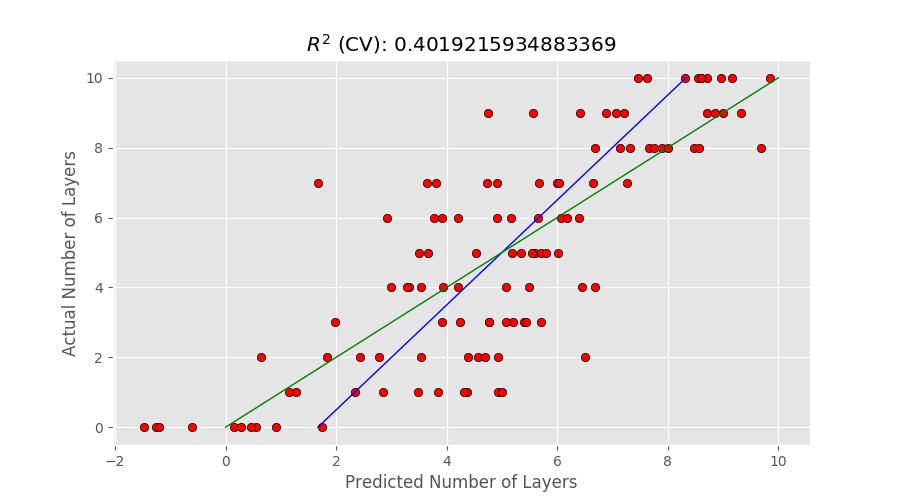

Precentage of correctly classified number of plastic layers: 0.25%
Precentage of correctly classified   meat vs plastic film(s): 0.99%


In [18]:
def test_pls_classifier(X, Y):
    pls_classifier = mypackage.PLS.optimise_pls_cv(X, Y, 20, plot_result=True)

    ######################################
    # Counting correctly classified items
    Y_hat = np.floor(pls_classifier.predict(X))
    Y_hat[Y_hat < 0] = 0

    numb_correct_layers = np.sum((np.squeeze(Y_hat) - Y) == 0)
    numb_correct_plastic_or_not = np.sum(((np.squeeze(Y_hat) == 0) - (Y) == 0) == 0)
    total_samples = len(Y_hat)

    print(f"Precentage of correctly classified number of plastic layers: {numb_correct_layers/total_samples:.2f}%")
    print(f"Precentage of correctly classified   meat vs plastic film(s): {numb_correct_plastic_or_not/total_samples:.2f}%")
    
    return pls_classifier

pls_classifier = test_pls_classifier(df[wavelengths], df['NumbLayers'])

# This is top 10 highest

<IPython.core.display.Javascript object>


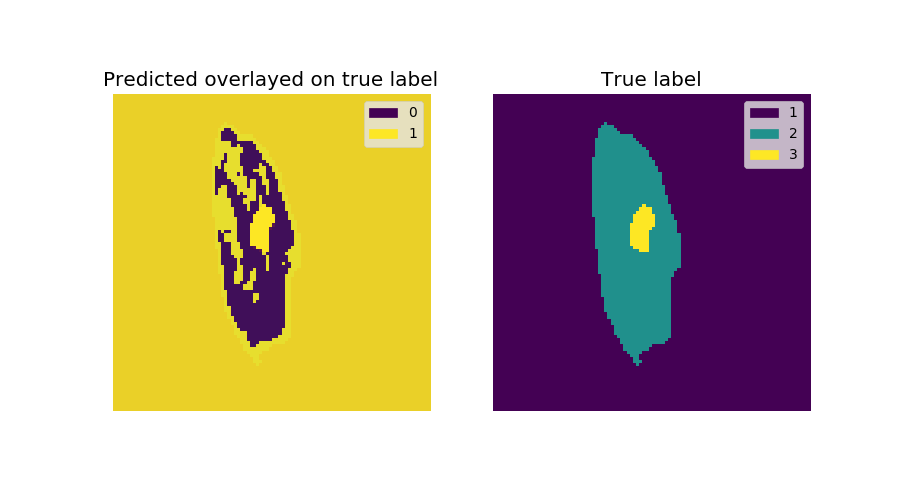

In [49]:
def predict_if_plastic_film(image):
    test = mypackage.StackTransform(image)
    Y_hat = np.floor(pls_classifier.predict(test.X_stack()))
    return test.Unstack(Y_hat, k=1)
    
Y_hat = predict_if_plastic_film(X[0:1])
Y_hat[Y_hat < 0] = 0
Y_hat[Y_hat > 0] = 1

numb_correctly_classified_as_plastic = np.sum(Y_hat == (Y[0:1] == 3)*1)
numb_incorrectly_classified_as_meat = np.sum(Y_hat != (Y[0:1] == 3)*1)

y_hat_img = np.squeeze(Y_hat)
y_true_img = np.squeeze(Y[0:1])
plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.title("Predicted overlayed on true label")
img = plt.imshow(y_hat_img)
plt.imshow(y_true_img, alpha=0.1)
mypackage.Dataset._Dataset__add_legend_to_image(y_hat_img.astype(int), img)#, ['Meat', 'Plastic'])
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("True label")
img = plt.imshow(y_true_img)
mypackage.Dataset._Dataset__add_legend_to_image(y_true_img, img)#, ['Belt', 'Meat', 'Plastic'])
plt.axis('off');



50% completed
Suggested number of components:  2

R2 calib: 0.113
R2 CV: -0.147
MSE calib: 7.319
MSE CV: 9.462


<IPython.core.display.Javascript object>


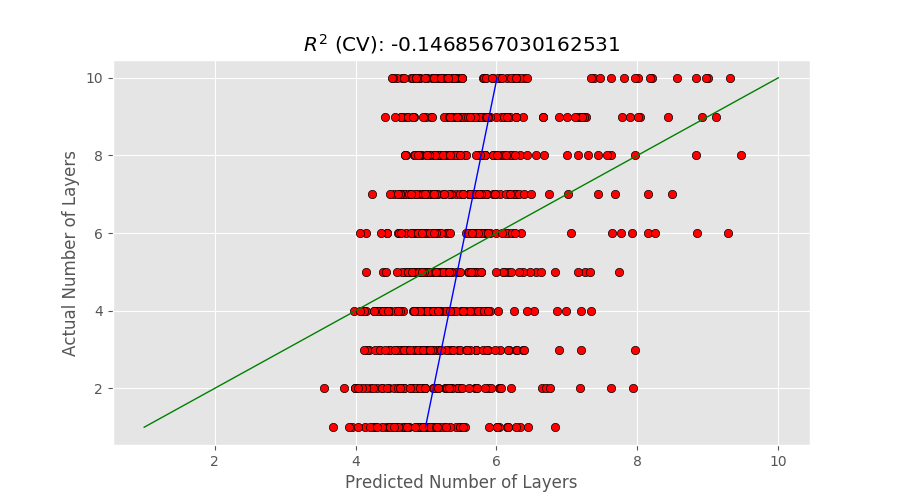

Precentage of correctly classified number of plastic layers: 0.11%
Precentage of correctly classified   meat vs plastic film(s): 1.00%


In [99]:
pls_classifier = test_pls_classifier(df_1stDiff[[col for col in df_1stDiff.columns if col != 'NumbLayers']], df_1stDiff['NumbLayers'])

When the top_10 filtering was done on the top_10 lowest valued pixels the PLS result seemd very good. However that did not scale wery well over the rest of the image. When the top_10 filtering is done on the top_10 highest valued pixels the result is worse, but does improve somewhat with a standard scaling.

This comment was based on a mistake:
    * "This result here above indicates that with a targeted prediction method, the number of layers can be classified to the precision of about $\pm 1$ layer."

The prediction is shown here above shows that the PSL algorithm that is trained on 10 pixels spectral response of each 0 to 10 layers of plastic film. This result shows that it is crucial to include more training data to capture the true variety of the collected images.

# Now iterate the same PLS method with more training data
In order to include more training data, the result might suffer from some poorly labeled pixels.

The PLS would require the materials to be sorted based on intensity of key material elements, which is difficult to figure out what should be used, maybe water content or amount of C-H chains.

PLS-DA would probably be better solution to this problem here.

In [87]:
print(f"The loaded files are:")
for file in file_names:
    print(f"\t{file}")
X, Y, info = mypackage.Dataset.load_files(file_names, '../data/tomra')
Y[Y == 3] = 0
Y[Y == 1] = 0

X_train, X_test, Y_train, Y_test = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)
print(X_train.shape, X_test.shape)

The loaded files are:
	20200213_113826_fillet_sample30
	20200213_113854_fillet_sample31
	20200213_113925_fillet_sample32
	20200213_113949_fillet_sample33
	20200213_114007_fillet_sample34
	20200213_114025_fillet_sample35
	20200213_114052_fillet_sample36
	20200213_114111_fillet_sample37
	20200213_114129_fillet_sample38
	20200213_114148_fillet_sample39
(7, 100, 100, 208) (3, 100, 100, 208)


50% completed
Suggested number of components:  17



<IPython.core.display.Javascript object>


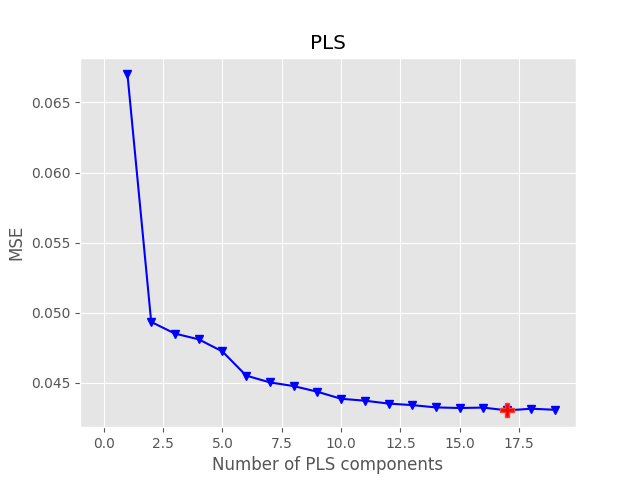

R2 calib: 0.913
R2 CV: 0.910
MSE calib: 0.042
MSE CV: 0.043


<IPython.core.display.Javascript object>


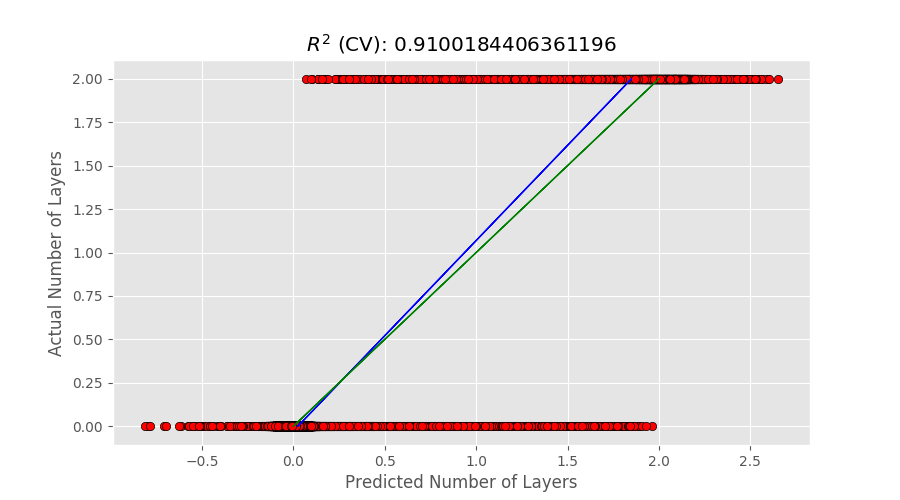

In [89]:
train = mypackage.StackTransform(X_train, Y_train)
pls = mypackage.PLS.optimise_pls_cv(train.X_stack(), train.Y_stack().ravel(), n_comp=20, plot_components=True, plot_result=True)

50% completed
Suggested number of components:  19



<IPython.core.display.Javascript object>


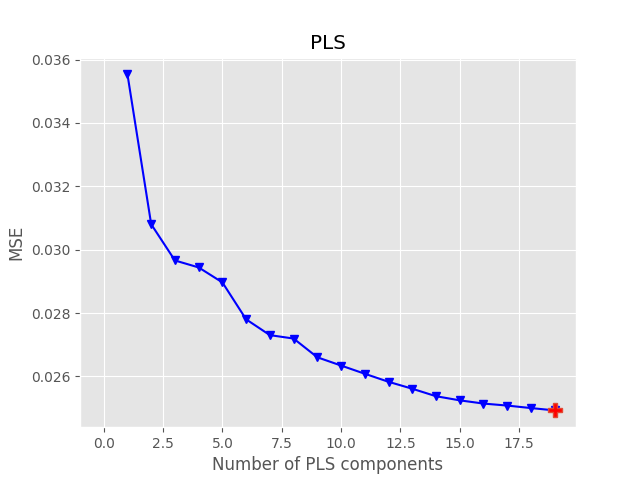

R2 calib: 0.817
R2 CV: 0.811
MSE calib: 0.024
MSE CV: 0.025


<IPython.core.display.Javascript object>


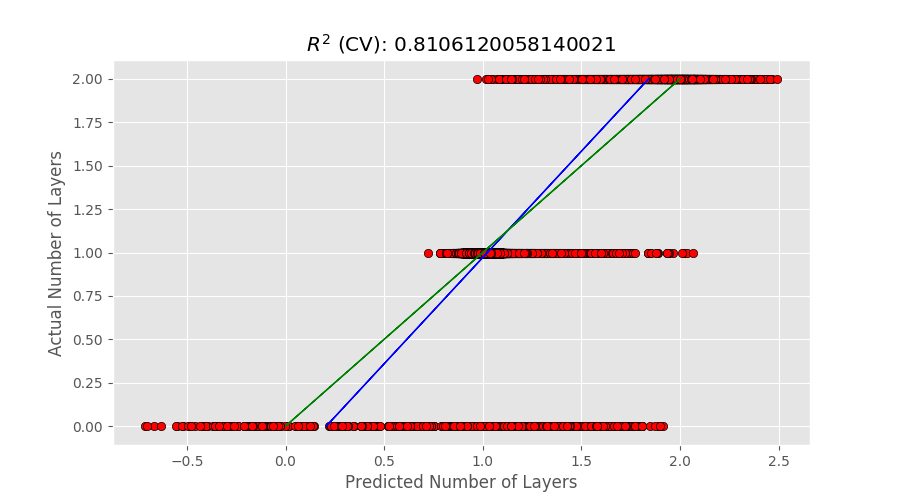

In [86]:
# pls = partial_least_squares(X_train, X_test, n_components=2)


train = mypackage.StackTransform(X_train, Y_train)
pls = mypackage.PLS.optimise_pls_cv(train.X_stack(), train.Y_stack().ravel(), n_comp=20, plot_components=True, plot_result=True)